Based on https://colab.research.google.com/drive/1YIfmkftLrz6MPTOO9Vwqrop2Q5llHIGK?usp=sharing
Talks about embeddings and predicting next char given 3 chars


In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [1]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [2]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    # initialize context with 0s which represent .
    context = [0] * block_size
    # . is the end of the word
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append for next iteration

  X = torch.tensor(X) # size is batch_size x block_size
  Y = torch.tensor(Y) # size is batch_size
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [6]:
# Sized
# Input matric X [number of inputs][block size]
# C[X] size [number of inputs][block size][embedding dimensions]
# W ==>  [block size * embedding_dimensions][neurons]

g = torch.Generator().manual_seed(2147483647)
# embedding: i size should be number of things to embed
#  second coordinate represents how many dimensions we want in embeddings
C = torch.randn([27, 10],generator=g) 
# X based on number of outputs from embeddings (here )
# Y size based on number of neuron in layer
W1 = torch.randn([30, 200],generator=g) 
# size: number of neurons in layer
b1 = torch.randn([200],generator=g)

W2 = torch.randn([200, 27],generator=g)
b2 = torch.randn([27],generator=g)
parameters = [C,W1,b1,W2,b2]
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [7]:
#  important for back propagation
for p in parameters:
  p.requires_grad = True

In [8]:
# control learn rate 
# exponential spacing
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [9]:
lri = []
lossi = []
stepi = []

In [17]:
train_batch_size = 32
for i in range(200000):
    # mini batch
    ix = torch.randint(0,Xtr.shape[0],(train_batch_size,))
    
    # forward pass
    emb = C[Xtr[ix]]
    # view changes size in place
    # we want to make chars_to_look_back*embediing dimensions single layer
    h = torch.tanh(emb.view(-1,30)@W1 + b1)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])


     # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # not using lr using exponential spacing for now
    #  that's used to plot and learn best rate
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

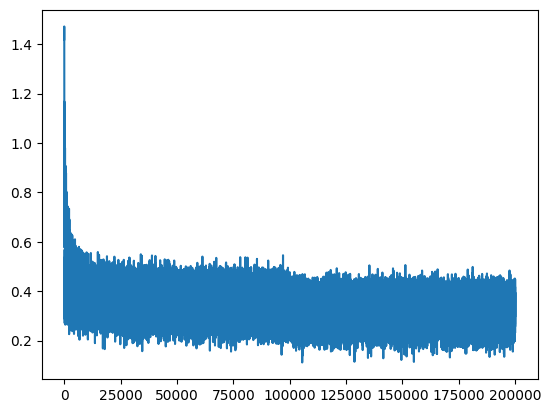

In [18]:
plt.plot(stepi, lossi)

In [19]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1097, grad_fn=<NllLossBackward0>)

In [20]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1510, grad_fn=<NllLossBackward0>)

In [21]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1553, grad_fn=<NllLossBackward0>)

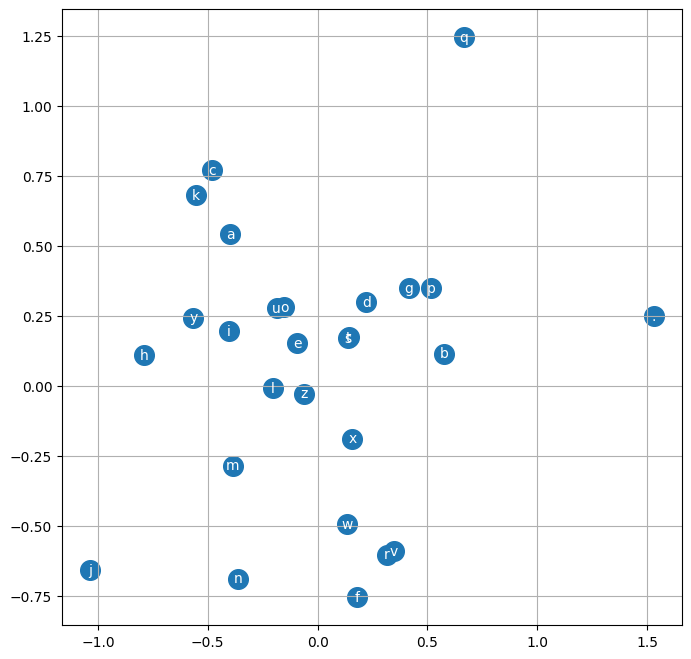

In [22]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [23]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khyirrix.
thiyah.
cassie.
rahnen.
den.
rhe.
kaeli.
neronia.
chaiiv.
kaleigh.
ham.
joce.
quinn.
sulin.
alianni.
wayell.
dearynix.
kaelissrah.
